In [1]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import sys
path = '/Work/EPE/ML4pi/'
sys.path.append(path)
import util.ml_util as mu
from util.ml_util import cell_meta

In [2]:

path_prefix = '/Work/EPE/ML4pi/'
plotpath = path_prefix+'plots/'
modelpath_c = path_prefix+''
modelpath = path_prefix+''

layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

In [3]:
import sys
sys.path.append(path_prefix)
from util import resolution_util as ru
from util import plot_util as pu
from util import ml_util as mu
import uproot3 as ur

In [4]:
data_path = path_prefix + "v7/"
pionp_file = ur.open(data_path + "piplus.root")
pp_tree = pionp_file["ClusterTree"]
print(pp_tree)

<TTree b'ClusterTree' at 0x021f89e248b0>


In [6]:
branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt',
            'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 
            'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 
            'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
pp = pp_tree.pandas.df(branches, flatten=False)

In [7]:
pp['clusterEoverCalib'] = pp.clusterE / pp.cluster_ENG_CALIB_TOT
pp['clusterEoverTruth'] = pp.clusterE / pp.truthE
pp['cluster_ENG_ALL'] = pp.cluster_ENG_CALIB_TOT + pp.cluster_ENG_CALIB_OUT_T + pp.cluster_ENG_CALIB_DEAD_TOT
# regression variables
pp['logE'] = np.log(pp.clusterE)
pp['logECalib'] = np.log(pp.cluster_ENG_CALIB_TOT)
pp['logECalibAll'] = np.log(pp.cluster_ENG_ALL)

In [8]:
from sklearn.preprocessing import StandardScaler
# create scaler
scaler_e = StandardScaler()
scaler_cal = StandardScaler()
scaler_calAll = StandardScaler()
# fit and transform in one step
pp['s_logE'] = scaler_e.fit_transform(pp['logE'].to_numpy().reshape(-1,1))
pp['s_logECalib'] = scaler_cal.fit_transform(pp['logECalib'].to_numpy().reshape(-1,1))
pp['s_logECalibAll'] = scaler_calAll.fit_transform(pp['logECalibAll'].to_numpy().reshape(-1,1))

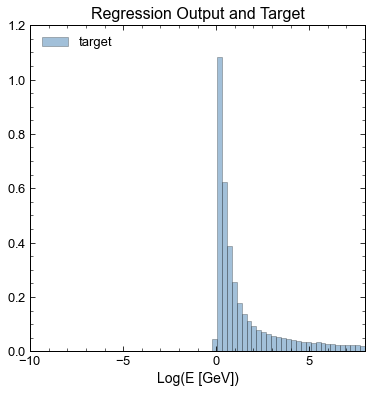

In [9]:
## PREDICTIONS AND TRUTH ##
bins = np.linspace(-5,8,50, endpoint=True)
fig = plt.figure(figsize=(6,6))
plt.hist(pp.cluster_ENG_CALIB_TOT, color='steelblue', bins=bins, density=True, alpha=.5, edgecolor='black', label='target')
#plt.hist(np.log(preds[:,0]), color='coral', bins=bins, density=True, alpha=.5, edgecolor='black', label='network')
plt.title('Regression Output and Target', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(-10,8)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(loc='upper left')
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_STSC_targetPreds_3000batch_LR1e-2_2021-07-016.png', format='png')
plt.show()

In [10]:
eclib = np.nonzero(pp['s_logECalibAll'].array)
eclib[0].shape

(435967,)

In [11]:
cell_meta

{'EMB1': {'cell_size_phi': 0.098,
  'cell_size_eta': 0.0031,
  'len_phi': 4,
  'len_eta': 128},
 'EMB2': {'cell_size_phi': 0.0245,
  'cell_size_eta': 0.025,
  'len_phi': 16,
  'len_eta': 16},
 'EMB3': {'cell_size_phi': 0.0245,
  'cell_size_eta': 0.05,
  'len_phi': 16,
  'len_eta': 8},
 'TileBar0': {'cell_size_phi': 0.1,
  'cell_size_eta': 0.1,
  'len_phi': 4,
  'len_eta': 4},
 'TileBar1': {'cell_size_phi': 0.1,
  'cell_size_eta': 0.1,
  'len_phi': 4,
  'len_eta': 4},
 'TileBar2': {'cell_size_phi': 0.1,
  'cell_size_eta': 0.2,
  'len_phi': 4,
  'len_eta': 2}}

In [12]:
# convert nn datasets into pfn datasets

def nn_pfn_conver(tree, layers):
    """
    Convert Tree dataset input to PFN format, eliminate zeros
    """
    layer_rPerp = {"EMB1": 1540.,
                   "EMB2": 1733.,
                   "EMB3": 1930.,
                   "TileBar0": 2450.,
                   "TileBar1": 3010.,
                   "TileBar2": 3630.}
    pfn_datasets = []
    for layer in layers:
        imgs = tree.array(layer)
        idx,eta,phi = np.nonzero(imgs)
        eta = ((cell_meta[layer]['len_eta'])/2-eta)*(cell_meta[layer]['cell_size_eta'])
        phi = (-(cell_meta[layer]['len_phi'])/2+phi)*(cell_meta[layer]['cell_size_phi'])
        energy = imgs[np.nonzero(imgs)]
        rperp = np.ones(len(idx)) * layer_rPerp[layer]
        # t_flag = np.zeros(len(eta))
        array_tuple = (idx, energy, eta, phi, rperp) # add Trackflag in the future
        mixed_img = np.column_stack(array_tuple)
        result = np.zeros((435967, max(np.bincount(idx)) , 4))
        k = 0
        for i in range(len(idx)):
            if (i>0) and (idx[i]>idx[i-1]):
                k = 0
            result[idx[i], k, :] = mixed_img[i, 1::]
            k += 1
        pfn_datasets.append(result)
    return np.concatenate(pfn_datasets, axis=1)


In [13]:
lay = "EMB3"
emb3 = pp_tree.array(lay)
idx, eta, phi = np.nonzero(emb3)
# phi = (-(cell_meta[lay]['len_phi'])/2+phi)*(cell_meta[lay]['cell_size_phi'])
max(phi)

15

In [14]:
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
X = nn_pfn_conver(pp_tree, layers)
Xraw = X


In [15]:
Y = np.concatenate[pp.cluster_ENG_CALIB_TOT, pp.clusterE, pp.clusterEta]
print(X.shape)
print(Y.shape)

(435967, 636, 4)
(435967,)


In [16]:
np.savez(data_path + 'X_img_pfn.npz', X)
np.savez(data_path + 'Y_img_pfn.npz', Y)

In [17]:
from time import process_time as cput

In [18]:
X = Xraw

In [19]:
Xraw[:,:,2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))

In [21]:
a = Xraw

In [22]:
phi_mask = a[:,:,2] != 0
print(a[:,:,2][phi_mask])
max(scaler(a[:,:,2][phi_mask]))

[-0.098  -0.098   0.098  ... -0.049  -0.0245 -0.0245]


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\alber\AppData\Local\Temp/ipykernel_30152/1788452862.py", line 3, in <module>
    max(scaler(a[:,:,2][phi_mask]))
TypeError: 'MinMaxScaler' object is not callable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\interactiveshell.py", line 2064, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\core\ultratb.py", line 1101, in get_records
    return _fixed_getinner

TypeError: object of type 'NoneType' has no len()

C:\Users\alber\AppData\Local\Temp/ipykernel_9956/1710826133.py:3: RuntimeWarning: invalid value encountered in log
  a[:,:,2][phi_mask] = np.log(a[:,:,2][phi_mask])
C:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\axes\_axes.py:6565: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
C:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\matplotlib\axes\_axes.py:6566: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
C:\Users\alber\anaconda3\envs\tensorflow-gpu\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


(array([0., 1., 2., 3., 4., 5.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

<Figure size 799.992x599.976 with 0 Axes>

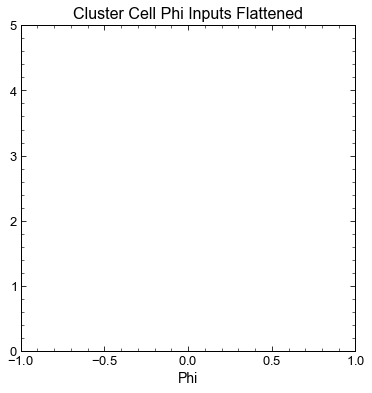

In [ ]:
phi_mask = a[:,:,2] != 0
cellPhi_std = np.std(a[:,:,2][phi_mask])
a[:,:,2][phi_mask] = np.log(a[:,:,2][phi_mask])
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-1,1,50, endpoint=True)
plt.hist(a[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

In [ ]:
## Normalize rPerp to 1/3630
rPerp_mask = X[:,:,3] != 0
X[:,:,3][rPerp_mask] = X[:,:,3][rPerp_mask]/3630.

## Energy Values that are not zero!
E_nonZeroMask = X[:,:,0] != 0
X[:,:,0][E_nonZeroMask] = np.log(X[:,:,0][E_nonZeroMask])
cellE_mean = np.mean(X[:,:,0][E_nonZeroMask])
cellE_std = np.std(X[:,:,0][E_nonZeroMask])
X[:,:,0][E_nonZeroMask] = (X[:,:,0][E_nonZeroMask] - cellE_mean)/cellE_std

## Eta and Phi
# do nothing for now as a control and check performance
eta_mask = X[:,:,1] > -10
X[:,:,1][eta_mask] = np.exp(X[:,:,1][eta_mask]) - 1

phi_mask = X[:,:,2] > -10
X[:,:,2][phi_mask] = np.exp(X[:,:,2][phi_mask]) - 1

In [ ]:
X[:,:,0][E_nonZeroMask]

array([nan, nan, nan, ..., nan, nan, nan])

<Figure size 799.992x599.976 with 0 Axes>

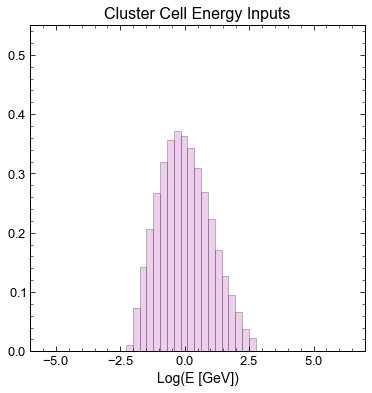

<Figure size 799.992x599.976 with 0 Axes>

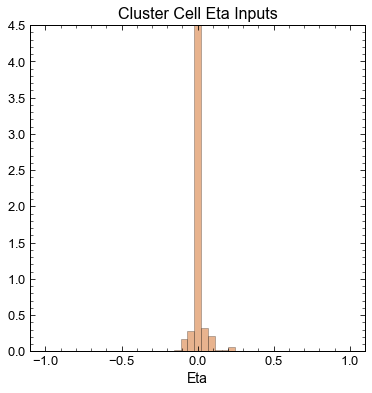

<Figure size 799.992x599.976 with 0 Axes>

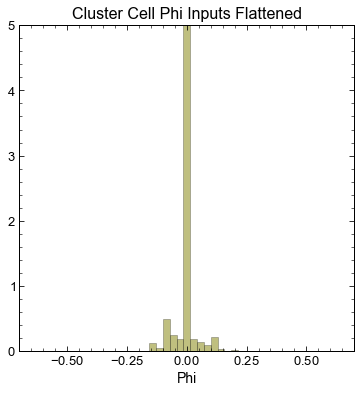

<Figure size 799.992x599.976 with 0 Axes>

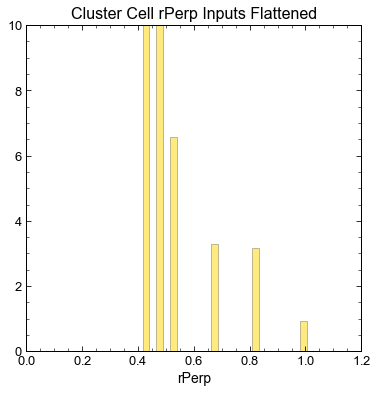

In [ ]:
############
## ENERGY ##
############
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
ebins = np.linspace(-6,7, 50, endpoint=True)
plt.hist(X[:,:,0][E_nonZeroMask], color='plum', bins=ebins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Energy Inputs', fontsize=16)
plt.xlabel('Log(E [GeV])', fontsize=14)
plt.xlim(np.min(ebins),np.max(ebins))
plt.ylim(0,.55)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_Einputs_2020-07-01.png', format='png')
plt.show()

#########
## ETA ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
etabins = np.linspace(-1.1,1.1,50, endpoint=True)
plt.hist(X[:,:,1][eta_mask], color='chocolate', bins=etabins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Eta Inputs', fontsize=16)
plt.xlabel('Eta', fontsize=14)
plt.xlim(np.min(etabins),np.max(etabins))
plt.ylim(0,4.5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_EtaInputs_2021-07-08.png', format='png')
plt.show()

#########
## PHI ##
#########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
phibins = np.linspace(-0.7,0.7,50, endpoint=True)
plt.hist(X[:,:,2][phi_mask], color='olive', bins=phibins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell Phi Inputs Flattened', fontsize=16)
plt.xlabel('Phi', fontsize=14)
plt.xlim(np.min(phibins),np.max(phibins))
plt.ylim(0,5)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_PhiInputs_2021-07-08.png', format='png')
plt.show()

###########
## RPERP ##
###########
plt.cla(); plt.clf()
fig = plt.figure(figsize=(6,6))
Rbins = np.linspace(-0,1.2,50, endpoint=True)
plt.hist(X[:,:,3][rPerp_mask], color='gold', bins=Rbins, density=True, alpha=.5, edgecolor='black')
plt.title('Cluster Cell rPerp Inputs Flattened', fontsize=16)
plt.xlabel('rPerp', fontsize=14)
plt.xlim(np.min(Rbins),np.max(Rbins))
plt.ylim(0,10)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.tight_layout()
# plt.savefig('Regression_Plots/July/XY_tracks_multipleClusters_med_rPerpInputs_2021-07-08.png', format='png')
plt.show()